In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np



In [2]:
# Load dataset
merged = pd.read_csv("data_cleaning_forProjict.csv")


In [3]:
#check dataset
# 1A) Quick sanity checks

print("merged.shape =", merged.shape)
print("merged columns:", merged.columns.tolist())
print(merged.isna().sum())
print(merged.dtypes)

# 1B) Ensure proper dtypes
merged['datetime'] = pd.to_datetime(merged['timestamp'], unit='s', errors='coerce')

# Light downcasting to save memory (safe)
merged['userId']  = pd.to_numeric(merged['userId'], downcast='integer')
merged['movieId'] = pd.to_numeric(merged['movieId'], downcast='integer')
merged['rating']  = pd.to_numeric(merged['rating'],  downcast='float')


if 'genres' in merged.columns:
    merged['genres'] = merged['genres'].astype('category')

# 1C) Build weekly key and aggregate
merged['week'] = merged['datetime'].dt.to_period('W').dt.start_time

weekly = (
    merged.groupby('week')
          .agg(count=('rating','size'), avg_rating=('rating','mean'))
          .reset_index()
          .sort_values('week')
)

print("\nWeekly head:")
print(weekly.head())
print("\nWeekly tail:")
print(weekly.tail())
print("\nWeekly shape:", weekly.shape)

merged.shape = (31965051, 9)
merged columns: ['userId', 'movieId', 'rating', 'timestamp', 'datetime', 'title', 'genres', 'year', 'clean_title']
userId          0
movieId         0
rating          0
timestamp       0
datetime        0
title           0
genres          0
year            0
clean_title    35
dtype: int64
userId           int64
movieId          int64
rating         float64
timestamp        int64
datetime        object
title           object
genres          object
year             int64
clean_title     object
dtype: object

Weekly head:
        week  count  avg_rating
0 1995-01-09      4    3.750000
1 1996-01-29    168    3.601191
2 1996-02-05     49    3.836735
3 1996-02-12     42    3.928571
4 1996-02-19    145    3.510345

Weekly tail:
           week  count  avg_rating
1436 2023-09-11  20119    3.569164
1437 2023-09-18  23067    3.517037
1438 2023-09-25  22200    3.608604
1439 2023-10-02  22329    3.464150
1440 2023-10-09   7837    3.486092

Weekly shape: (1441, 3)


In [5]:
merged = merged.dropna(subset=['clean_title'])
print(merged.isna().sum())


userId         0
movieId        0
rating         0
timestamp      0
datetime       0
title          0
genres         0
year           0
clean_title    0
week           0
dtype: int64


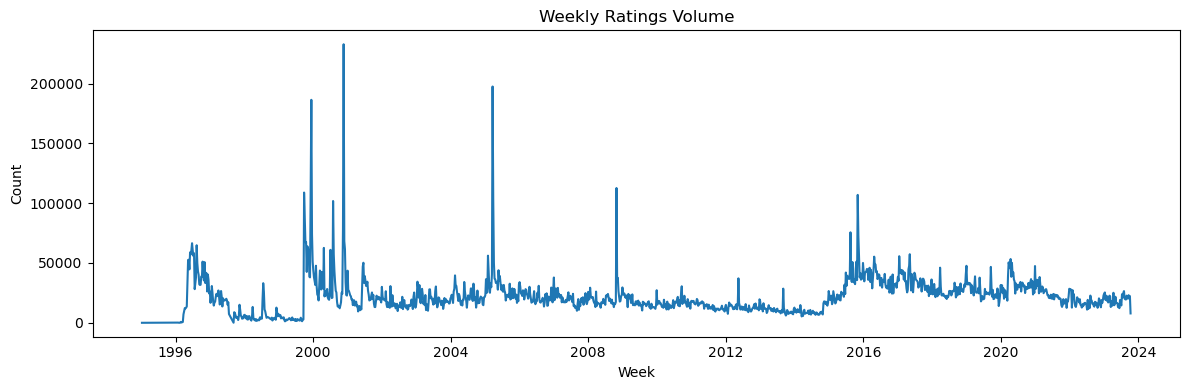

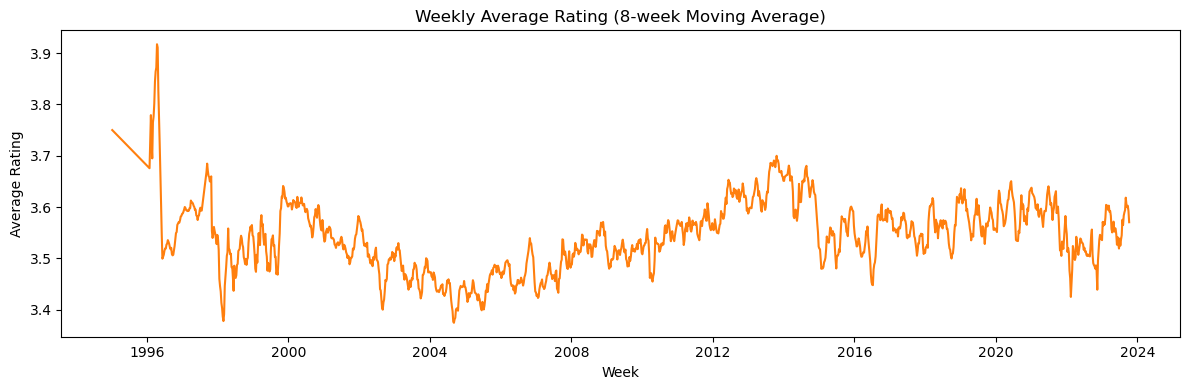

In [6]:
# Plot 1: Weekly ratings volume
plt.figure(figsize=(12,4))
plt.plot(weekly['week'], weekly['count'], color='tab:blue')
plt.title('Weekly Ratings Volume')
plt.xlabel('Week')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot 2: Weekly average rating (smoothed with moving average)
plt.figure(figsize=(12,4))
avg_ma = weekly['avg_rating'].rolling(8, min_periods=1).mean()
plt.plot(weekly['week'], avg_ma, color='tab:orange')
plt.title('Weekly Average Rating (8-week Moving Average)')
plt.xlabel('Week')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

In [7]:
print(weekly['count'].head())
print(weekly['count'].tail())
print(weekly['count'].describe())

0      4
1    168
2     49
3     42
4    145
Name: count, dtype: int64
1436    20119
1437    23067
1438    22200
1439    22329
1440     7837
Name: count, dtype: int64
count      1441.000000
mean      22182.547536
std       15552.819298
min           4.000000
25%       14022.000000
50%       19520.000000
75%       27110.000000
max      232802.000000
Name: count, dtype: float64


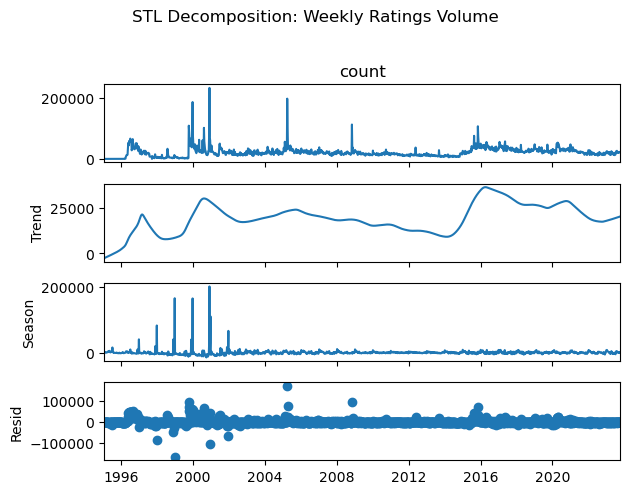

In [8]:
# Ensure the 'week' column is the index
y = weekly.set_index('week')['count']

# Make the series a regular weekly frequency and fill missing weeks
y = y.asfreq('W', method='pad')   # you can also use fill_value=0 if preferred

# STL decomposition
stl = STL(y, period=52, robust=True)
res = stl.fit()

# Plot the results
res.plot()
plt.suptitle('STL Decomposition: Weekly Ratings Volume', y=1.02)
plt.tight_layout()
plt.show()

SARIMAX Forecasting

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Make sure weekly counts are continuous
y = weekly.set_index('week')['count'].asfreq('W', method='pad')

# Train/test split (last 26 weeks for testing)
h = 26
train, test = y.iloc[:-h], y.iloc[-h:]

# Fit SARIMAX model (seasonal period = 52 weeks for yearly seasonality)
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)

# Forecast horizon
forecast = fit.get_forecast(steps=h)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Evaluate forecast accuracy
mae  = np.mean(np.abs(forecast_mean - test))
mape = np.mean(np.abs((forecast_mean - test) / np.maximum(test, 1))) * 100

print(f"Forecast MAE: {mae:,.0f}")
print(f"Forecast MAPE: {mape:.2f}%")

# Plot forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test.index,
                 forecast_ci['lower count'],
                 forecast_ci['upper count'],
                 color='pink', alpha=0.3, label='95% CI')
plt.title('Weekly Ratings Volume: 26-Week Forecast')
plt.xlabel('Week')
plt.ylabel('Ratings Count')
plt.legend()
plt.tight_layout()
plt.show()